# Code for "Enhancing Wound Healing via Deep Reinforcement Learning for Optimal Therapeutics"

## Import Python Packages

In [1]:
from __future__ import division

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import time
import sys
sys.path.insert(0, '../..')

import math
import random
import copy
import numpy as np
import pandas as pd
from collections import deque
from scipy.integrate import odeint
from control import lqr
import scipy.integrate as it

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
from torch.autograd.functional import jacobian
from torch.utils.tensorboard import SummaryWriter

from algs.td3 import Agent_TD3
from algs.ppo import Agent_PPO
from envs.env import WoundEnv, SimpleEnv
from cfgs.config import GetParameters

from algs.ode54 import Transformer, Agent_Trans
from algs.a2c import Agent_A2C
from algs.dqn import Agent_DQN
from envs.env import WoundEnv, SimpleEnv, LinearEnv, dynamics, dynamics5, linear_dynamic
from cfgs.config import GetParameters


## Configure Hyperparameters

In [2]:
args = GetParameters()
nenv = WoundEnv(args)

st_nl = nenv.reset()
states_buf = copy.deepcopy(st_nl)
for t in range(nenv.t_nums - 1):
    st_tp1_nl, reward_nl, done_nl, _ = nenv.step(0)
    st_nl = st_tp1_nl
    states_buf = np.vstack((states_buf, st_nl))

In [3]:
# Create Deeplearning models for learning the linear representation of nonlinear models
device = torch.device("cuda:0" if torch.cuda.is_available() and args.gpu else "cpu")
model = Transformer(in_dim=5, out_dim=4, nscale=args.nscale).to(device)

In [4]:
# Configure Directories for data

model_dir = './data/rl4wound_paper_res/non_ctr/models_map524/'
figs_dir = './data/rl4wound_paper_res/non_ctr/figs_map524/'
data_dir = './data/rl4wound_paper_res/non_ctr/data_map524/'

dirs = [figs_dir, data_dir]

for dirtmp in dirs:
    if not os.path.exists(dirtmp):
        os.makedirs(dirtmp)

In [5]:
def readPercentile(data, nstep=50):
    
    data_buf = [[dt[idx] for idx in range(0, len(dt), nstep)]
                   for dt in data]

    ln = len(data_buf[0])

    print('rewards collection down. ' + str(len(data_buf)))

    rewards = data_buf

    def stat_rewards(rewards, stat):
        return [stat([r[i] for r in rewards]) for i in range(ln)]

    def sigma(l):
        mean = sum(l) / float(len(l))
        return math.sqrt(sum([(r - mean) ** 2 for r in l]) / (len(l) - 1))

    rewards_mean = stat_rewards(rewards, lambda l: sum(l) / float(len(l)))
    rewards_sigma = stat_rewards(rewards, sigma)
    rewards_up = [rewards_mean[i] + rewards_sigma[i] for i in range(len(rewards_mean))]
    rewards_down = [rewards_mean[i] - rewards_sigma[i] for i in range(len(rewards_mean))]
    rewards_final = [r[-1] for r in rewards]

    rewards_median = stat_rewards(rewards, lambda l: np.percentile(l, 50))
    rewards_90 = stat_rewards(rewards, lambda l: np.percentile(l, 90))
    rewards_75 = stat_rewards(rewards, lambda l: np.percentile(l, 75))
    rewards_25 = stat_rewards(rewards, lambda l: np.percentile(l, 25))
    rewards_10 = stat_rewards(rewards, lambda l: np.percentile(l, 10))

    return rewards_median, rewards_10, rewards_25, rewards_75, rewards_90


In [6]:
khs_buf, kis_buf, kps_buf, mse_buf = [], [], [], []

for sd in range(4):
    df = pd.read_csv(data_dir + 'all_training_logs_in_one_file_sd_{}.csv'.format(sd))
    mse = df.loc[df['metric'] == 'Loss/train_mse'].value.values
    khs = df.loc[df['metric'] == 'Loss/K_h'].value.values
    kis = df.loc[df['metric'] == 'Loss/K_i'].value.values
    kps = df.loc[df['metric'] == 'Loss/K_p'].value.values
    
    mse_buf.append(mse)
    khs_buf.append(khs)
    kis_buf.append(kis)    
    kps_buf.append(kps)

rewards collection down. 15
rewards collection down. 15
rewards collection down. 15
rewards collection down. 15


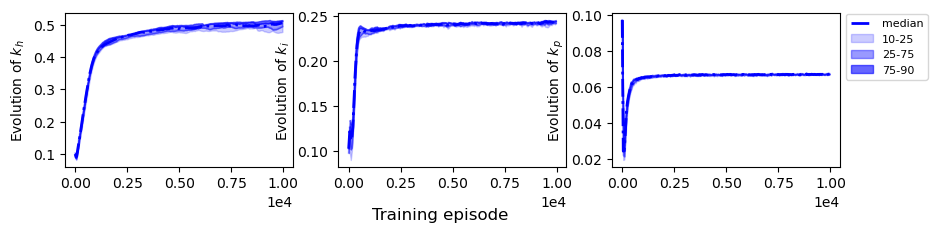

In [7]:
def plot_percitile(figs_dir, name):
    
    khs_buf, kis_buf, kps_buf, mse_buf = [], [], [], []

    for sd in range(15):
        df = pd.read_csv(data_dir + 'all_training_logs_in_one_file_sd_{}.csv'.format(sd))
        mse = df.loc[df['metric'] == 'Loss/train_mse'].value.values
        khs = df.loc[df['metric'] == 'Loss/K_h'].value.values
        kis = df.loc[df['metric'] == 'Loss/K_i'].value.values
        kps = df.loc[df['metric'] == 'Loss/K_p'].value.values

        mse_buf.append(mse)
        khs_buf.append(khs)
        kis_buf.append(kis)    
        kps_buf.append(kps)
    
    nstep = 50
    xrange = range(0, len(kps_buf[0]), nstep)
    
    khs_median, khs_10, khs_25, khs_75, khs_90 = readPercentile(khs_buf, nstep)
    kis_median, kis_10, kis_25, kis_75, kis_90 = readPercentile(kis_buf, nstep)
    kps_median, kps_10, kps_25, kps_75, kps_90 = readPercentile(kps_buf, nstep)
    mse_median, mse_10, mse_25, mse_75, mse_90 = readPercentile(mse_buf, nstep)
    
    fig = plt.figure(figsize=(10, 2), num=3)
    ax = fig.add_subplot(131)
    ax.plot(xrange, khs_75, color = 'blue', alpha=0.2)
    ax.plot(xrange, khs_median, color = 'blue', linestyle ='-.', linewidth = 2, label=r'median')
    ax.plot(xrange, khs_25, color = 'blue', alpha=0.2)
    ax.fill_between(xrange, khs_10, khs_25, color = 'blue', alpha=0.2, label='10-25')
    ax.fill_between(xrange, khs_25, khs_75, color = 'blue', alpha=0.4, label='25-75')
    ax.fill_between(xrange, khs_75, khs_90, color = 'blue', alpha=0.6, label='75-90')

    ax.set_ylabel(r'Evolution of $k_h$')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

    ax = fig.add_subplot(132)
    ax.plot(xrange, kis_75, color = 'blue', alpha=0.2)
    ax.plot(xrange, kis_median, color = 'blue', linestyle ='-.', linewidth = 2, label=r'median')
    ax.plot(xrange, kis_25, color = 'blue', alpha=0.2)
    ax.fill_between(xrange, kis_10, kis_25, color = 'blue', alpha=0.2, label='10-25')
    ax.fill_between(xrange, kis_25, kis_75, color = 'blue', alpha=0.4, label='25-75')
    ax.fill_between(xrange, kis_75, kis_90, color = 'blue', alpha=0.6, label='75-90')
    
    ax.set_ylabel(r'Evolution of $k_i$')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    ax = fig.add_subplot(133)
    ax.plot(xrange, kps_75, color = 'blue', alpha=0.2)
    ax.plot(xrange, kps_median, color = 'blue', linestyle ='-.', linewidth = 2, label=r'median')
    ax.plot(xrange, kps_25, color = 'blue', alpha=0.2)
    ax.fill_between(xrange, kps_10, kps_25, color = 'blue', alpha=0.2, label='10-25')
    ax.fill_between(xrange, kps_25, kps_75, color = 'blue', alpha=0.4, label='25-75')
    ax.fill_between(xrange, kps_75, kps_90, color = 'blue', alpha=0.6, label='75-90')

    ax.set_ylabel(r'Evolution of $k_p$')
    ax.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    ax.legend(loc='center right', bbox_to_anchor=(1.41, 0.78), fontsize=8)
    
    fig.text(0.5, -0.15, 'Training episode', ha='center', fontsize=12)
    plt.savefig(figs_dir + 'train_noctr_ks.pdf', format='pdf', bbox_inches='tight', pad_inches = 0)
        
plot_percitile(figs_dir, 'ks')

In [8]:
state_linear_chainrule_buf, state_linear_linearapx_buf, state_non_linear_buf, state_non_linear_est_buf = [], [], [], []
cstate_linear_buf = []

heal_day = None
model.load_state_dict(torch.load(model_dir + 'checkpoint_ctr_False_ep_{}_seed0.pth'.format(1619)))

for t in range(nenv.t_nums - 1):
    state_non_linear = states_buf[t, :]
    new_tissue = state_non_linear.reshape(5, args.n_cells)[4, 0]
    if new_tissue > 0.95 and heal_day is None:
        heal_day = nenv.t_span[t] / 3.0

    state_non_linear_buf.append(state_non_linear.reshape(5, args.n_cells))
    state_non_linear_5 = state_non_linear.reshape(5, args.n_cells)[:, 0]
    state_non_linear_tensor = torch.from_numpy(state_non_linear_5).float().to(device).view(1, -1)

    state_linear, state_linear_AN, state_non_linear_aprx = model(state_non_linear_tensor)
    state_non_linear_est_buf.append(state_non_linear_aprx.cpu().data.numpy().reshape(5, -1))

    jac = jacobian(model.map524, state_non_linear_tensor, create_graph=False)

    n_cells, spt, X_pump, beta, gamma1, gamma2, rho, mu, alphaTilt, power, kapa, Lam, DTilt, DTilt_n = args.n_cells, args.spt, args.X_pump, args.beta, args.gamma1, args.gamma2, args.rho, args.mu, args.alphaTilt, args.power, args.kapa, args.Lam, args.DTilt, args.DTilt_n
    arrgs = (n_cells, spt, X_pump, beta, gamma1, gamma2, rho, mu, alphaTilt, power, kapa, Lam, DTilt, DTilt_n)
    dxdt = dynamics5(state_non_linear, None, 0, arrgs)
    dxdt_5 = dxdt.reshape(5, args.n_cells)[:, 0]
    Jn_dxdt = torch.matmul(jac[0, :, 0, :], torch.from_numpy(dxdt_5).float().to(device).view(-1, 1)).view(1, -1)

    cstate_linear_buf.append(state_linear.cpu().data.numpy())
    state_linear_chainrule_buf.append(Jn_dxdt.cpu().data.numpy())
    state_linear_linearapx = state_linear_AN
    state_linear_linearapx_buf.append(state_linear_linearapx.cpu().data.numpy())


cstate_linear_buf = np.array(cstate_linear_buf).squeeze()
state_linear_chainrule_buf = np.array(state_linear_chainrule_buf).squeeze()
state_linear_linearapx_buf = np.array(state_linear_linearapx_buf).squeeze()
state_non_linear_buf = np.array(state_non_linear_buf).squeeze()
state_non_linear_est_buf = np.array(state_non_linear_est_buf).squeeze()
# action_buf = np.array(action_buf).squeeze()
trange = (nenv.t_span / 3.0)[:-1]

state_linear_linearapx_noctr_buf = copy.deepcopy(state_linear_linearapx_buf)
state_linear_chainrule_noctr_buf = copy.deepcopy(state_linear_chainrule_buf)

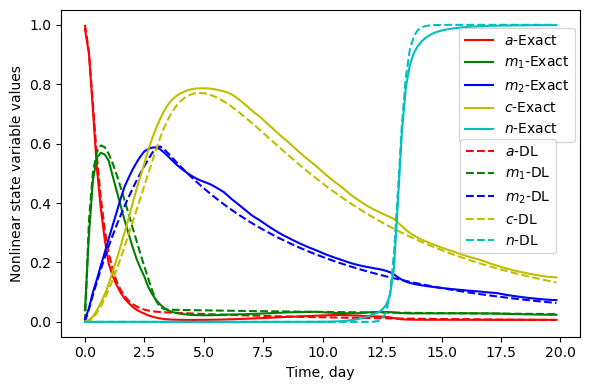

In [9]:
im_scal = 0.78
leg_pos = (1, 0.5)

titles1 = ['$a$-Exact', '$m_1$-Exact', '$m_2$-Exact', '$c$-Exact', '$n$-Exact']
titles2 = ['$a$-DL', '$m_1$-DL', '$m_2$-DL', '$c$-DL', '$n$-DL']
colors = ['r', 'g', 'b', 'y', 'c']
lines = []

fig = plt.figure(figsize=(6, 4), num=1)
ax = fig.add_subplot(111)
for i in range(5):
    if i == 3:
        ax.plot(trange, state_non_linear_buf[:, i, 0] / 3.0, color=colors[i], linestyle='--', label=r'{}'.format(titles2[i]))
        lines += ax.plot(trange, state_non_linear_est_buf[:, i] / 3.0, color=colors[i], linestyle='-')
    else:
        ax.plot(trange, state_non_linear_buf[:, i, 0], color=colors[i], linestyle='--', label=r'{}'.format(titles2[i]))
        lines += ax.plot(trange, state_non_linear_est_buf[:, i], color=colors[i], linestyle='-')

ax.legend(loc='center right', bbox_to_anchor=(0.967, 0.43))

# Create the second legend and add the artist manually.
from matplotlib.legend import Legend
leg = Legend(ax, lines, [r'$a$-Exact', r'$m_1$-Exact', r'$m_2$-Exact', r'$c$-Exact', r'$n$-Exact'],
             bbox_to_anchor=(0.99, 0.77), 
             loc='center right', borderaxespad=0, frameon=True)
ax.add_artist(leg)

ax.set_xlabel('Time, day')
ax.set_ylabel('Nonlinear state variable values')
plt.tight_layout()
plt.savefig(figs_dir + 'nonlinearIDT.pdf', format='pdf', pad_inches = 0)
plt.show()

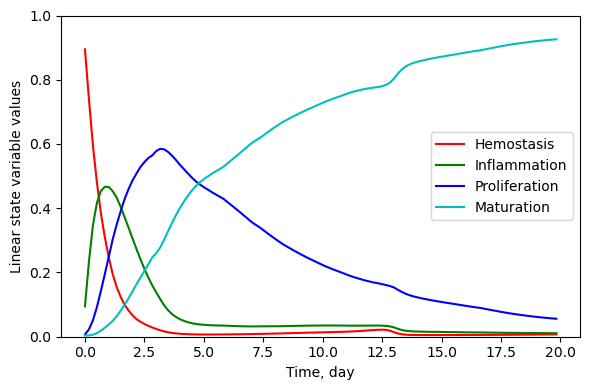

In [10]:

titles = ['Hemostasis', 'Inflammation', 'Proliferation', 'Maturation']
colors = ['r', 'g', 'b', 'c']
fig = plt.figure(figsize=(6, 4), num=1)
ax = fig.add_subplot(111)
for i in range(4):
    ax.plot(trange, cstate_linear_buf[:, i], color=colors[i], linestyle='-', label=titles[i])
ax.legend(loc='center right')
ax.set_ylabel('Linear state variable values')
ax.set_xlabel('Time, day')
ax.set_ylim(0, 1)

plt.tight_layout()
plt.savefig(figs_dir + 'linearIDT.pdf', format='pdf', pad_inches = 0)
plt.show()


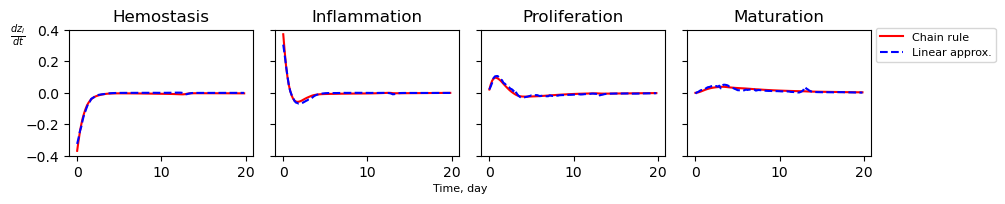

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 2), sharey=True, subplot_kw=dict(frameon=True))

titles = ['Hemostasis', 'Inflammation', 'Proliferation', 'Maturation']

axes[0].set_ylim(-0.4, 0.4)

for idx in range(4):
    axes[idx].plot(trange, state_linear_linearapx_buf[:, idx], color='r', linestyle='-', label=r'Chain rule')
    axes[idx].plot(trange, state_linear_chainrule_buf[:, idx], color='b', linestyle='--', label=r'Linear approx.')
    axes[idx].set_title(titles[idx], fontsize=12)

axes[3].legend(loc='center right', bbox_to_anchor=(1.71, 0.88), fontsize=8)

axes[0].set_ylabel(r'$\frac{dz_i}{dt}$', ha='left', rotation=0, labelpad=1, fontsize=10)
axes[0].yaxis.set_label_coords(-0.32, 0.85)
fig.text(0.46, 0.013, 'Time, day', ha='center', fontsize=8)

plt.tight_layout()

plt.savefig(figs_dir + 'res_nonctr_ode.pdf', format='pdf', pad_inches = 0)

# DRL Control

In [12]:
model_ctr_dir = './data/rl4wound_paper_res/ctr/models_map524/'
figs_ctr_dir = './data/rl4wound_paper_res/ctr/figs_map524/'
data_ctr_dir = './data/rl4wound_paper_res/ctr/data_map524/'

dirs = [figs_ctr_dir, data_ctr_dir]

for dirtmp in dirs:
    if not os.path.exists(dirtmp):
        os.makedirs(dirtmp)

In [13]:
args = GetParameters()
args.nscale = 5
nenv = WoundEnv(args)

device = torch.device("cuda:0" if torch.cuda.is_available() and args.gpu else "cpu")
model = Transformer(in_dim=5, out_dim=4, nscale=args.nscale).to(device)
agent = Agent_A2C(nenv, args)
nenv.theta_space = np.linspace(0, 10, args.action_size)
wound_size_space = np.linspace(0, 3, args.n_cells)

trange = nenv.t_span[:-1] / 3.0

In [14]:
ep = 7924
model.load_state_dict(torch.load(model_ctr_dir + 'mapper_ctr_True_ep_{}.pth'.format(ep)))
agent.model.load_state_dict(torch.load(model_ctr_dir + 'agent_ctr_True_ep_{}.pth'.format(ep)))

<All keys matched successfully>

In [15]:
args.ctr = False
state_non_linear = nenv.reset()
wound_size_noctr = []
heal_day = None
for t in range(nenv.t_nums - 1):

    new_tissue = state_non_linear.reshape(5, args.n_cells)[4, 0]

    if new_tissue > 0.95 and heal_day is None:
        heal_day = nenv.t_span[t] / 3.0
    
    if len(np.where(state_non_linear.reshape(5, 100)[4, :] >= 0.95)[0]) == 0:
        ws = 99
    else:
        ws = np.min(np.where(state_non_linear.reshape(5, 100)[4, :] >= 0.95)[0])
    wound_size_noctr.append(wound_size_space[ws])
    
    state_next_non_linear, reward_2_abandon, done_2_abandon, info = nenv.step(0)
    state_non_linear = state_next_non_linear

In [16]:
def actuator(t, t1, dt):
    y = 0
    if t > t1 and t < t1 + dt:
        y = 1
    if t > t1 and t < t1 + 1:
        y = t - t1
    if t > t1 + dt - 1 and t < t1 + dt:
        y = -t + t1 + dt
    return y

args.ctr = True
args.cont = True
state_non_linear = nenv.reset()
wound_size_bfs = []
act_bfs = []
heal_day = None
for t in range(nenv.t_nums - 1):

    new_tissue = state_non_linear.reshape(5, args.n_cells)[4, 0]

    if new_tissue > 0.95 and heal_day is None:
        heal_day = nenv.t_span[t] / 3.0
    
    if len(np.where(state_non_linear.reshape(5, 100)[4, :] >= 0.95)[0]) == 0:
        ws = 99
    else:
        ws = np.min(np.where(state_non_linear.reshape(5, 100)[4, :] >= 0.95)[0])
    wound_size_bfs.append(wound_size_space[ws])
    
    u = actuator(nenv.t_span[t], args.t1, args.dt)
    act_bfs.append(u)
    state_next_non_linear, reward_2_abandon, done_2_abandon, info = nenv.step(u)
    state_non_linear = state_next_non_linear

In [17]:
args.ctr = True
args.cont = False
state_non_linear = nenv.reset()
wound_size_noDL = []
act_noDL = []
nenv.theta_space = np.linspace(0, 2, args.action_size)
heal_day = None
for t in range(nenv.t_nums - 1):

    new_tissue = state_non_linear.reshape(5, args.n_cells)[4, 0]

    if new_tissue > 0.95 and heal_day is None:
        heal_day = nenv.t_span[t] / 3.0
    
    if len(np.where(state_non_linear.reshape(5, 100)[4, :] >= 0.95)[0]) == 0:
        ws = 99
    else:
        ws = np.min(np.where(state_non_linear.reshape(5, 100)[4, :] >= 0.95)[0])
    wound_size_noDL.append(wound_size_space[ws])
    
    state_non_linear_5 = state_non_linear.reshape(5, args.n_cells)[:, 0]
    state_non_linear_tensor = torch.from_numpy(state_non_linear_5).float().to(device).view(1, -1)
    
    u = agent.act(state_non_linear_tensor.cpu().data.numpy().squeeze())
    
    react = nenv.theta_space[u]
    act_noDL.append(react / 2.0)
    
    state_next_non_linear, reward_2_abandon, done_2_abandon, info = nenv.step(u)
    state_non_linear = state_next_non_linear

In [18]:
state_linear_chainrule_buf, state_linear_linearapx_buf, state_non_linear_buf, state_non_linear_est_buf = [], [], [], []
cstate_linear_buf = []
action_buf = []
wound_size_ctr = []

heal_day = None

args.ctr = True
state_non_linear = nenv.reset()
nenv.theta_space = np.linspace(0, 10, args.action_size)
for t in range(nenv.t_nums - 1):

    new_tissue = state_non_linear.reshape(5, args.n_cells)[4, 0]

    if new_tissue > 0.95 and heal_day is None:
        heal_day = nenv.t_span[t] / 3.0
    
    if len(np.where(state_non_linear.reshape(5, 100)[4, :] >= 0.95)[0]) == 0:
        ws = 99
    else:
        ws = np.min(np.where(state_non_linear.reshape(5, 100)[4, :] >= 0.95)[0])

    wound_size_ctr.append(wound_size_space[ws])

    state_non_linear_buf.append(state_non_linear.reshape(5, args.n_cells))
    state_non_linear_5 = state_non_linear.reshape(5, args.n_cells)[:, 0]
    state_non_linear_tensor = torch.from_numpy(state_non_linear_5).float().to(device).view(1, -1)
    # state_non_linear_tensor[:, 3] /= 3.0

    # selection action based using DRL
    u = agent.act(state_non_linear_tensor.cpu().data.numpy().squeeze()) if args.ctr and heal_day is None else 0
    state_next_non_linear, reward_2_abandon, done_2_abandon, info = nenv.step(u)

    state_linear, state_linear_AN, state_non_linear_aprx = model(state_non_linear_tensor)
    state_non_linear_est_buf.append(state_non_linear_aprx.cpu().data.numpy().reshape(5, -1))

    jac = jacobian(model.map524, state_non_linear_tensor, create_graph=True)

    n_cells, spt, X_pump, beta, gamma1, gamma2, rho, mu, alphaTilt, power, kapa, Lam, DTilt, DTilt_n = args.n_cells, args.spt, args.X_pump, args.beta, args.gamma1, args.gamma2, args.rho, args.mu, args.alphaTilt, args.power, args.kapa, args.Lam, args.DTilt, args.DTilt_n
    arrgs = (n_cells, spt, X_pump, beta, gamma1, gamma2, rho, mu, alphaTilt, power, kapa, Lam, DTilt, DTilt_n)
    dxdt = dynamics5(state_non_linear, None, u, arrgs)
    dxdt_5 = dxdt.reshape(5, args.n_cells)[:, 0]
    Jn_dxdt = torch.matmul(jac[0, :, 0, :], torch.from_numpy(dxdt_5).float().to(device).view(-1, 1)).view(1, -1)

    # m1 macrophage
    v = state_non_linear_tensor.cpu().data.numpy()[:, 1][0]
    B = torch.from_numpy(np.array([[0, 0, 0, 0, 0],
                                   [0, -v, 0, 0, 0],
                                   [0, v, 0, 0, 0],
                                   [0, 0, 0, 0, 0],
                                   [0, 0, 0, 0, 0]])).float().to(device)
    u_tensor = torch.from_numpy(np.array([u, u, u, u, u])).float().to(device).view(-1, 1)
    Jn_bu = torch.matmul(jac[0, :, 0, :], torch.matmul(B, u_tensor)).view(1, -1)
    
    react = nenv.theta_space[u]
    action_buf.append(float(nenv.t_span[t] / 3.0 >= 0.5) * react / 10.0)

    cstate_linear_buf.append(state_linear.cpu().data.numpy())
    state_linear_chainrule_buf.append(Jn_dxdt.cpu().data.numpy())
    state_linear_linearapx = state_linear_AN + Jn_bu
    state_linear_linearapx_buf.append(state_linear_linearapx.cpu().data.numpy())

    state_non_linear = state_next_non_linear

cstate_linear_buf = np.array(cstate_linear_buf).squeeze()
state_linear_chainrule_buf = np.array(state_linear_chainrule_buf).squeeze()
state_linear_linearapx_buf = np.array(state_linear_linearapx_buf).squeeze()
state_non_linear_buf = np.array(state_non_linear_buf).squeeze()
state_non_linear_est_buf = np.array(state_non_linear_est_buf).squeeze()
action_buf = np.array(action_buf).squeeze()
trange = (nenv.t_span / 3.0)[:-1]


C:\ProgramData\anaconda3\Lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


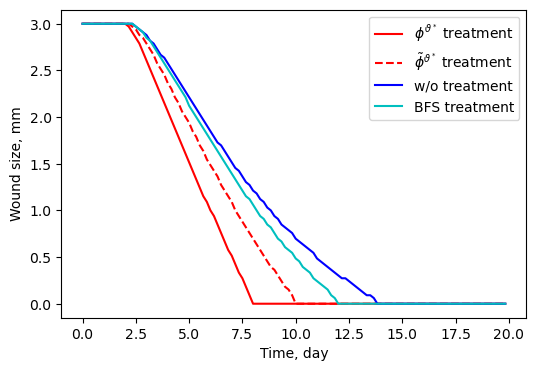

In [19]:
fig, axes = plt.subplots(figsize=(6, 4))

axes.plot(trange, wound_size_ctr, color='r', label=r'$\phi^{\vartheta^*}$ treatment')
axes.plot(trange, wound_size_noDL, color='r', linestyle='--', label=r'$\tilde{\phi}^{\vartheta^*}$ treatment')
axes.plot(trange, wound_size_noctr, color='b', linestyle='-', label='w/o treatment')
axes.plot(trange, wound_size_bfs, color='c', label='BFS treatment')

axes.legend()
axes.set_xlabel('Time, day')
axes.set_ylabel('Wound size, mm')

plt.savefig(figs_ctr_dir + 'ws_comp.pdf', format='pdf', bbox_inches='tight', pad_inches = 0)

In [20]:
act_DRL = np.zeros((args.t_nums, args.n_cells))
act_BFS = np.zeros((args.t_nums, args.n_cells))
act_NDL = np.zeros((args.t_nums, args.n_cells))

amplitude = 1.0
n = 1.25

for idx in range(len(action_buf)):
    for jdx in range(args.n_cells):
        x_z = (jdx - args.X_pump) / 10.0 
        tetta = action_buf[idx] * amplitude * np.exp(-((x_z ** 2) / n))
        act_DRL[idx][jdx] = tetta
        
        tetta = act_noDL[idx] * amplitude * np.exp(-((x_z ** 2) / n))
        act_NDL[idx][jdx] = tetta
        
        tetta = act_bfs[idx] * amplitude * np.exp(-((x_z ** 2) / n))
        act_BFS[idx][jdx] = tetta

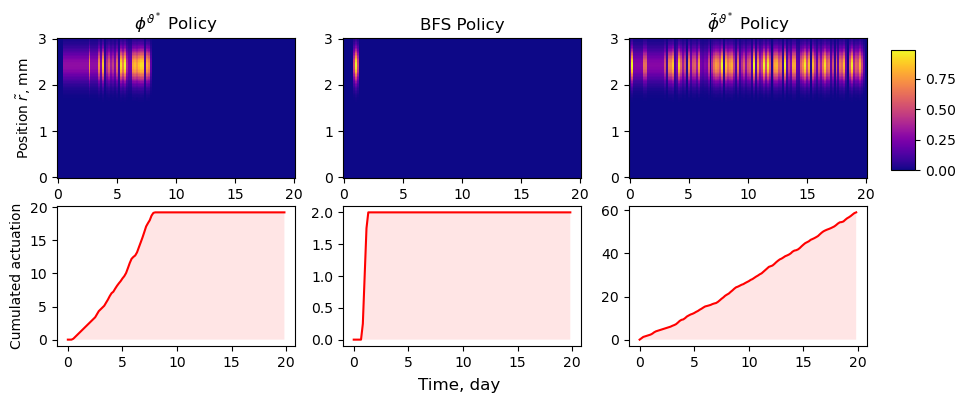

In [21]:
def plotsHeatMap(vectors):
    t = np.linspace(0, args.t_days, args.t_nums) / 3.0
    r = np.linspace(0, 3, args.n_cells)
    
    
    def mesh_2d_mat(tdays, radius, vector):
        @np.vectorize
        def value(tval, rval):
            tidx = np.where(t == tval)[0][0]
            ridx = np.where(r == rval)[0][0]
            val = vector[tidx][ridx]
            return val

        valuefun = value(tdays, radius)
        return valuefun

    
    tdays, radius = np.meshgrid(t, r)
    
    valuefunDRL = mesh_2d_mat(tdays, radius, vectors[0])
    valuefunBFS = mesh_2d_mat(tdays, radius, vectors[1])
    valuefunNRL = mesh_2d_mat(tdays, radius, vectors[2])
    z_minDRL, z_maxDRL = np.abs(valuefunDRL).min(), np.abs(valuefunDRL).max()
    z_minBFS, z_maxBFS = np.abs(valuefunBFS).min(), np.abs(valuefunBFS).max()
    z_minNRL, z_maxNRL = np.abs(valuefunNRL).min(), np.abs(valuefunNRL).max()
    
    cmap = plt.colormaps["plasma"]
    cmap = cmap.with_extremes(bad=cmap(0))
    
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 4), sharey=False)
    c = axes[0, 0].pcolormesh(tdays, radius, valuefunDRL, cmap=cmap, vmin=z_minDRL, vmax=z_maxDRL)
    c = axes[0, 1].pcolormesh(tdays, radius, valuefunBFS, cmap=cmap, vmin=z_minBFS, vmax=z_maxBFS)
    c = axes[0, 2].pcolormesh(tdays, radius, valuefunNRL, cmap=cmap, vmin=z_minNRL, vmax=z_maxNRL)

    
    axes[0, 0].set_ylabel(r'Position $\tilde r$, mm')
    axes[0, 0].set_title(r'$\phi^{\vartheta^*}$ Policy', fontsize=12)
    axes[0, 1].set_title('BFS Policy', fontsize=12)
    axes[0, 2].set_title(r'$\tilde{\phi}^{\vartheta^*}$ Policy', fontsize=12)
    
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.82, 0.55, 0.02, 0.3])
    fig.colorbar(c, cax=cbar_ax)
    
    cu_act = it.cumtrapz(vectors[3], initial=0)
    axes[1, 0].plot(trange, cu_act, c='r')
    axes[1, 0].fill_between(trange, 0, cu_act, where=0 <= cu_act,
                 facecolor='red', interpolate=True, alpha=0.1)
    axes[1, 0].set_ylabel('Cumulated actuation')
    
    cu_act = it.cumtrapz(vectors[4], initial=0)
    axes[1, 1].plot(trange, cu_act, c='r')
    axes[1, 1].fill_between(trange, 0, cu_act, where=0 <= cu_act,
                 facecolor='red', interpolate=True, alpha=0.1)
    
    cu_act = it.cumtrapz(vectors[5], initial=0)
    axes[1, 2].plot(trange, cu_act, c='r')
    axes[1, 2].fill_between(trange, 0, cu_act, where=0 <= cu_act,
                 facecolor='red', interpolate=True, alpha=0.1)
    fig.text(0.46, 0.0, 'Time, day', ha='center', fontsize=12)
    
    plt.savefig(figs_ctr_dir + 'policycomp.pdf', format='pdf', bbox_inches='tight', pad_inches = 0)
    
plotsHeatMap([act_DRL, act_BFS, act_NDL, action_buf, act_bfs, act_noDL])

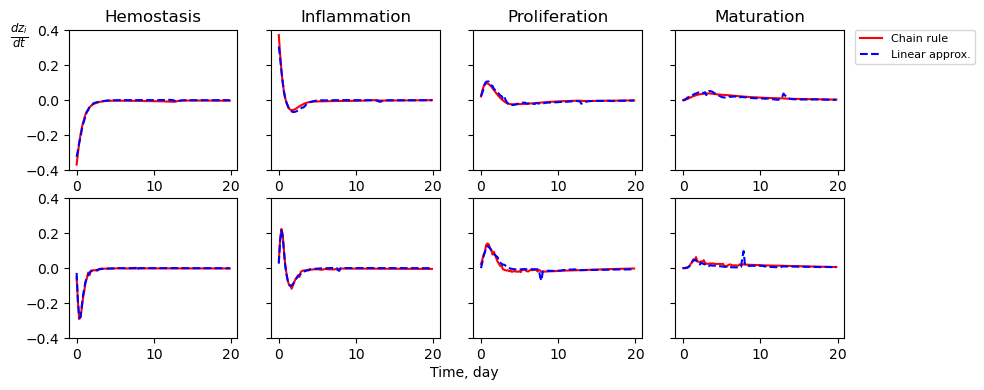

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 4), sharey=True, subplot_kw=dict(frameon=True))

titles = ['Hemostasis', 'Inflammation', 'Proliferation', 'Maturation']

axes[0, 0].set_ylim(-0.4, 0.4)
for idx in range(4):
    axes[0, idx].plot(trange, state_linear_linearapx_noctr_buf[:, idx], color='r', linestyle='-', label=r'Chain rule')
    axes[0, idx].plot(trange, state_linear_chainrule_noctr_buf[:, idx], color='b', linestyle='--', label=r'Linear approx.')
    axes[0, idx].set_title(titles[idx], fontsize=12)

axes[0, 0].set_ylabel(r'$\frac{dz_i}{dt}$', ha='left', rotation=0, labelpad=1, fontsize=12)
axes[0, 0].yaxis.set_label_coords(-0.35, 0.85)

axes[0, 3].legend(loc='center right', bbox_to_anchor=(1.81, 0.88), fontsize=8)


for idx in range(4):
    axes[1, idx].plot(trange, state_linear_linearapx_buf[:, idx], color='r', linestyle='-')
    axes[1, idx].plot(trange, state_linear_chainrule_buf[:, idx], color='b', linestyle='--')

fig.text(0.52, 0.013, 'Time, day', ha='center', fontsize=10)
plt.savefig(figs_ctr_dir + 'res_wwoctr_ode.pdf', format='pdf', bbox_inches='tight', pad_inches = 0)

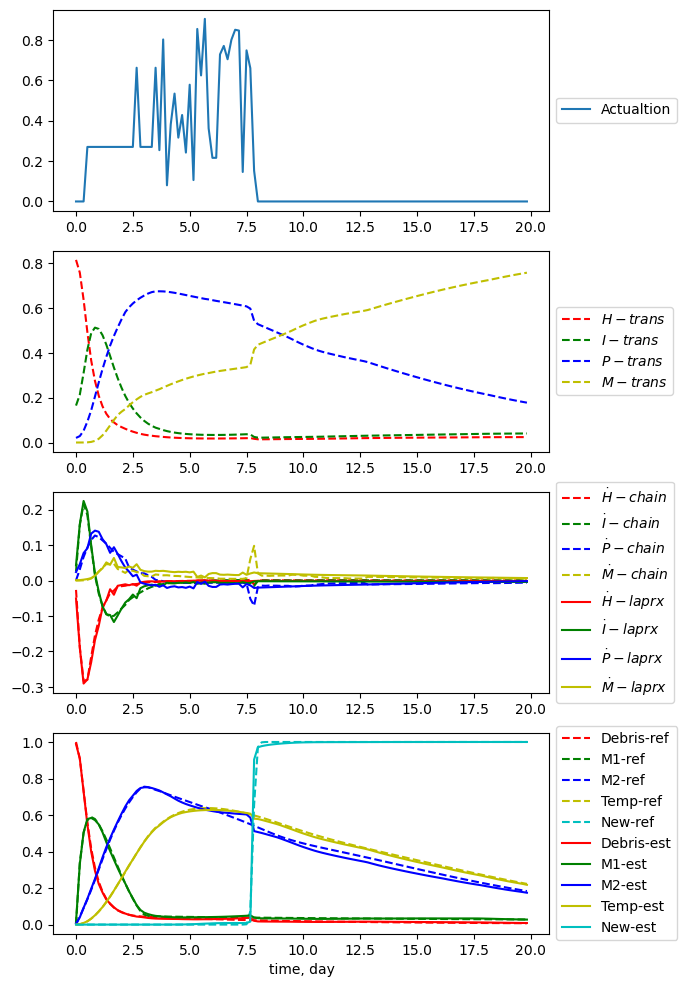

In [23]:
im_scal = 0.8
leg_pos = (1, 0.5)
fig = plt.figure(figsize=(8, 12), num=4)
plt.tight_layout()

ax = fig.add_subplot(411)
ax.plot(trange, action_buf, label='Actualtion')
ax.legend(loc='center left', bbox_to_anchor=leg_pos)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * im_scal, box.height])

ax = fig.add_subplot(412)
ax.plot(trange, cstate_linear_buf[:, 0], color='r', linestyle='--', label=r'$H-trans$')
ax.plot(trange, cstate_linear_buf[:, 1], color='g', linestyle='--', label=r'$I-trans$')
ax.plot(trange, cstate_linear_buf[:, 2], color='b', linestyle='--', label=r'$P-trans$')
ax.plot(trange, cstate_linear_buf[:, 3], color='y', linestyle='--', label=r'$M-trans$')
# ax.set_xlabel('time, sec')
ax.legend(loc='center left', bbox_to_anchor=leg_pos)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * im_scal, box.height])

ax = fig.add_subplot(413)
ax.plot(trange, state_linear_chainrule_buf[:, 0], color='r', linestyle='--', label=r'$\dot{H}-chain$')
ax.plot(trange, state_linear_chainrule_buf[:, 1], color='g', linestyle='--', label=r'$\dot{I}-chain$')
ax.plot(trange, state_linear_chainrule_buf[:, 2], color='b', linestyle='--', label=r'$\dot{P}-chain$')
ax.plot(trange, state_linear_chainrule_buf[:, 3], color='y', linestyle='--', label=r'$\dot{M}-chain$')

ax.plot(trange, state_linear_linearapx_buf[:, 0], color='r', linestyle='-', label=r'$\dot{H}-laprx$')
ax.plot(trange, state_linear_linearapx_buf[:, 1], color='g', linestyle='-', label=r'$\dot{I}-laprx$')
ax.plot(trange, state_linear_linearapx_buf[:, 2], color='b', linestyle='-', label=r'$\dot{P}-laprx$')
ax.plot(trange, state_linear_linearapx_buf[:, 3], color='y', linestyle='-', label=r'$\dot{M}-laprx$')

# ax.set_xlabel('time, sec')
ax.legend(loc='center left', bbox_to_anchor=leg_pos)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * im_scal, box.height])

ax = fig.add_subplot(414)
ax.plot(trange, state_non_linear_buf[:, 0, 0], color='r', linestyle='--', label='Debris-ref')
ax.plot(trange, state_non_linear_buf[:, 1, 0], color='g', linestyle='--', label='M1-ref')
ax.plot(trange, state_non_linear_buf[:, 2, 0], color='b', linestyle='--', label='M2-ref')
ax.plot(trange, state_non_linear_buf[:, 3, 0] / args.nscale, color='y', linestyle='--', label='Temp-ref')
ax.plot(trange, state_non_linear_buf[:, 4, 0], color='c', linestyle='--', label='New-ref')

ax.plot(trange, state_non_linear_est_buf[:, 0], color='r', linestyle='-', label='Debris-est')
ax.plot(trange, state_non_linear_est_buf[:, 1], color='g', linestyle='-', label='M1-est')
ax.plot(trange, state_non_linear_est_buf[:, 2], color='b', linestyle='-', label='M2-est')
ax.plot(trange, state_non_linear_est_buf[:, 3] / args.nscale, color='y', linestyle='-', label='Temp-est')
ax.plot(trange, state_non_linear_est_buf[:, 4], color='c', linestyle='-', label='New-est')

ax.set_xlabel('time, day')
ax.legend(loc='center left', bbox_to_anchor=leg_pos)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * im_scal, box.height])

plt.show()